# Wrangling Time Series Data

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Text(0, 0.5, 'Passengers')

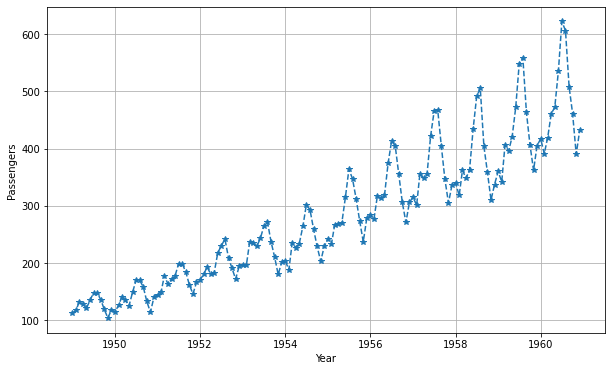

In [47]:
df["Month"] = pd.to_datetime(df["Month"]) #convert column to datetime
df.set_index("Month", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')

In [48]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [49]:
#check for missing values
df.isnull().values.any()
#There are no missing values in our dataset however, in bid to explain how we handle

False

In [50]:
#missing values, we will make a copy of our dataset and delete some values at random.
df_copy = df.copy()
rows = df_copy.sample(frac=0.1, random_state=0)
rows['Passengers'] = np.nan
df_copy.loc[rows.index, 'Passengers'] = rows['Passengers']
df_copy.isnull().sum()
#There are now 14 missing values in the dataset

Passengers    14
dtype: int64

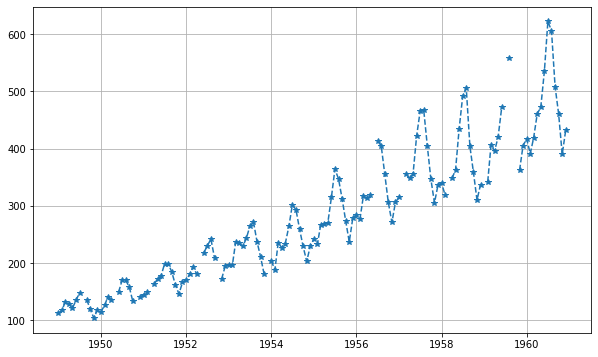

In [51]:
plt.figure(figsize=(10,6))
plt.plot(df_copy.index, df_copy.Passengers, '--', marker='*', )
plt.grid()

In [52]:
df_copy.isnull().values.any()

True

In [53]:
print(df_copy)

            Passengers
Month                 
1949-01-01       112.0
1949-02-01       118.0
1949-03-01       132.0
1949-04-01       129.0
1949-05-01       121.0
...                ...
1960-08-01       606.0
1960-09-01       508.0
1960-10-01       461.0
1960-11-01       390.0
1960-12-01       432.0

[144 rows x 1 columns]


In [54]:
#Filling missing data by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method='ffill')
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

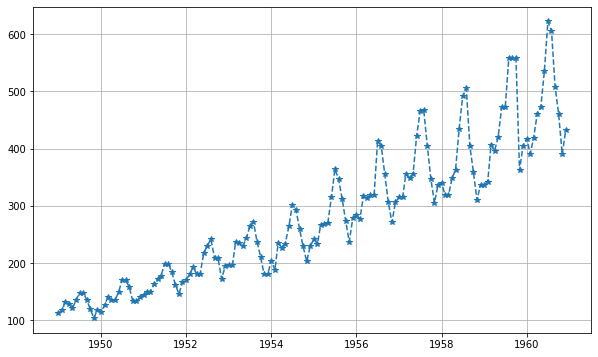

In [55]:
plt.figure(figsize=(10,6))
plt.plot(df_copy_ffill.index, df_copy_ffill.Passengers, '--', marker='*', )
plt.grid()

In [56]:
#Filling missing data by imputation - Backward fill
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

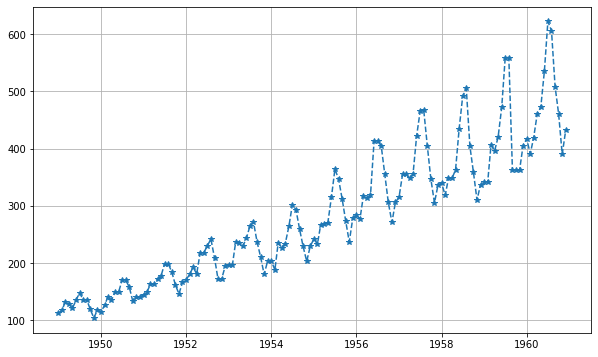

In [57]:
plt.figure(figsize=(10,6))
plt.plot(df_copy_bfill.index, df_copy_bfill.Passengers, '--', marker='*', )
plt.grid()

In [58]:
#Filling missing data by interpolation
df_copy_LIF = df_copy.interpolate(method='linear', limit_direction='forward')
df_copy_LIF.isnull().sum()

Passengers    0
dtype: int64

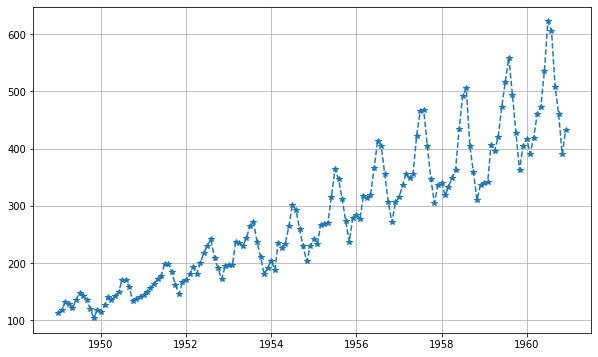

In [59]:
plt.figure(figsize=(10,6))
plt.plot(df_copy_LIF.index, df_copy_LIF.Passengers, '--', marker='*', )
plt.grid()

In [60]:
df_copy_LIB = df_copy.interpolate(method='linear', limit_direction='backward')
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

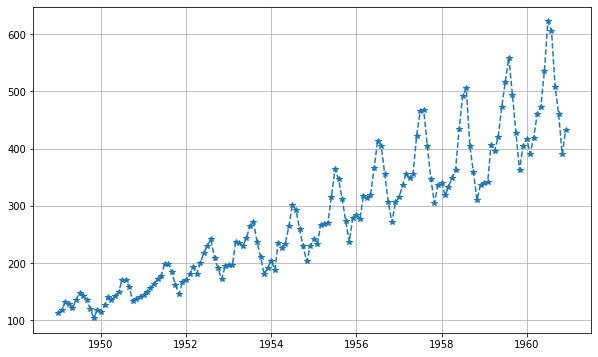

In [61]:
plt.figure(figsize=(10,6))
plt.plot(df_copy_LIB.index, df_copy_LIB.Passengers, '--', marker='*', )
plt.grid()

In [62]:
#Moving Average Smoothning
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(12).mean()
print(df_MA)

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]


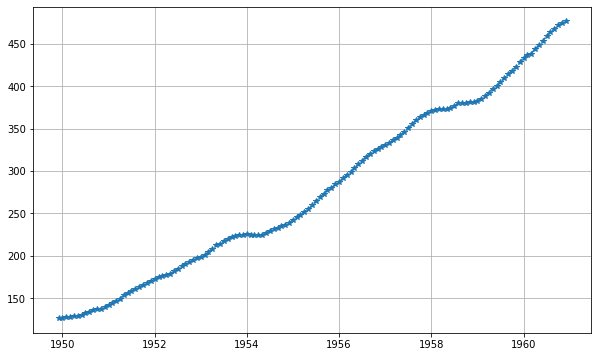

In [63]:
plt.figure(figsize=(10,6))
plt.plot(df_MA.index, df_MA['Passengers'].rolling(12).mean(), '--', marker='*', )
plt.grid()

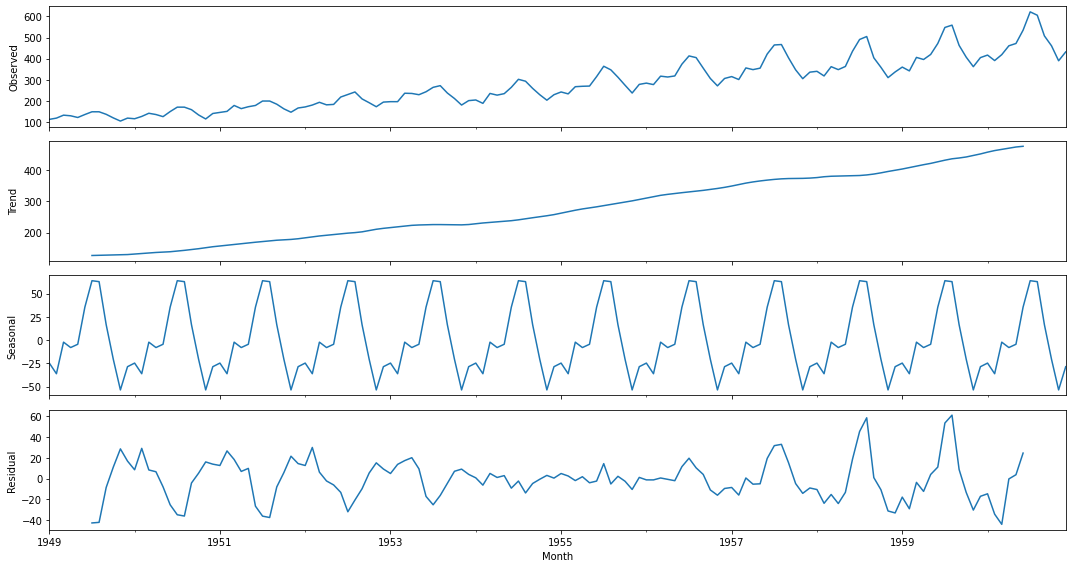

In [64]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df['Passengers'], model='additive')
decompose_series.plot()
plt.show()

ADF Statistic: 0.815368879206047
p-value: 0.991880243437641
No. of lags used: 13
No. of observations used : 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


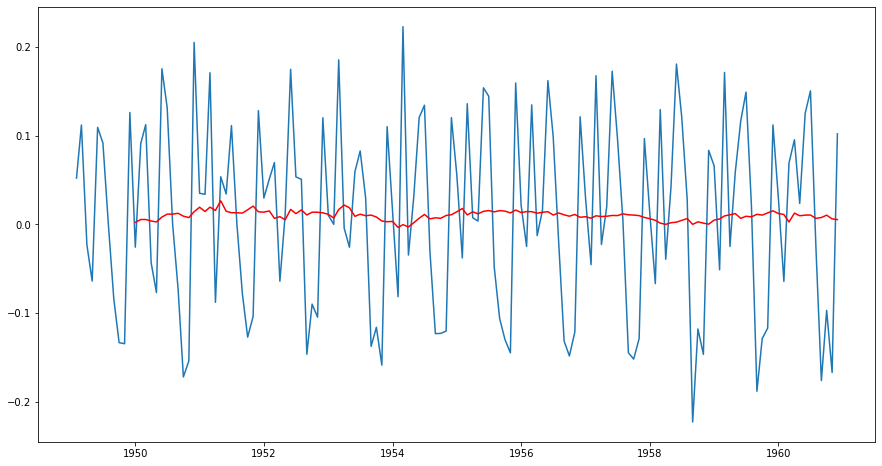

In [65]:
#The decomposed time series show an obvious increasing trend and seasonality variations. Recall that we have initially plotted the moving average on the last 12 months which showed that it varies with time. This suggests that the data is not stationary. We will now perform an ADF test to confirm this speculation

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}') 



#From the results obtained, the p-value is greater than the critical value at a 5% #significance level and, the ADF statistic is greater that any of the critical values obtain. #This confirms that the series is indeed non-stationary.
#Convert time series to stationary by removing trend and seasonality
#Transformation and Differencing
df_log = np.log(df)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index, df_diff.Passengers, '-')
plt.plot(df_diff.rolling(12).mean(), color='red')

In [66]:
df_diff.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


In [67]:
#Downsample to quarterly data points
df_quarterly = df.resample('3M').mean()


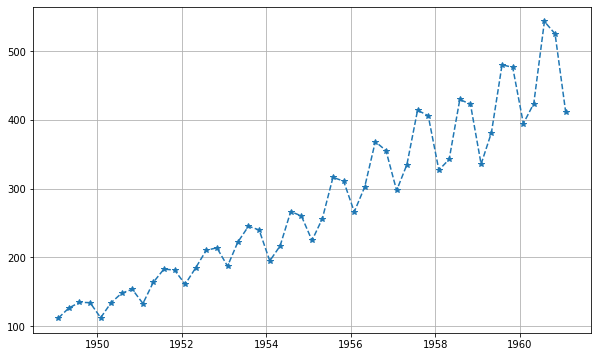

In [68]:
plt.figure(figsize=(10,6))
plt.plot(df_quarterly.index, df_quarterly.Passengers, '--', marker='*', )
plt.grid()

In [69]:
#Upsample to daily data points
df_daily = df.resample('D').mean()

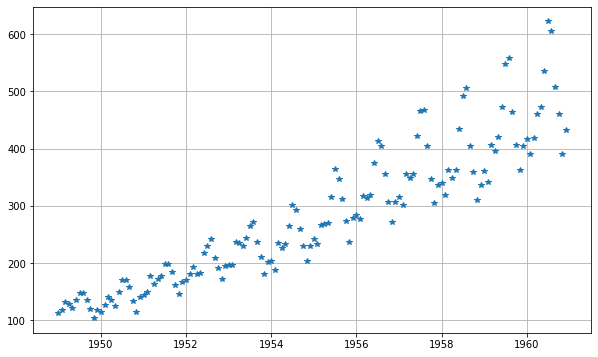

In [70]:
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.Passengers, '--', marker='*', )
plt.grid()

# Time Series Forecasting Using Stochastic Models

In [79]:
df_diff = df_diff.fillna(method='bfill')

In [81]:
df_diff = df_diff.interpolate(method='linear', limit_direction='forward')

In [73]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

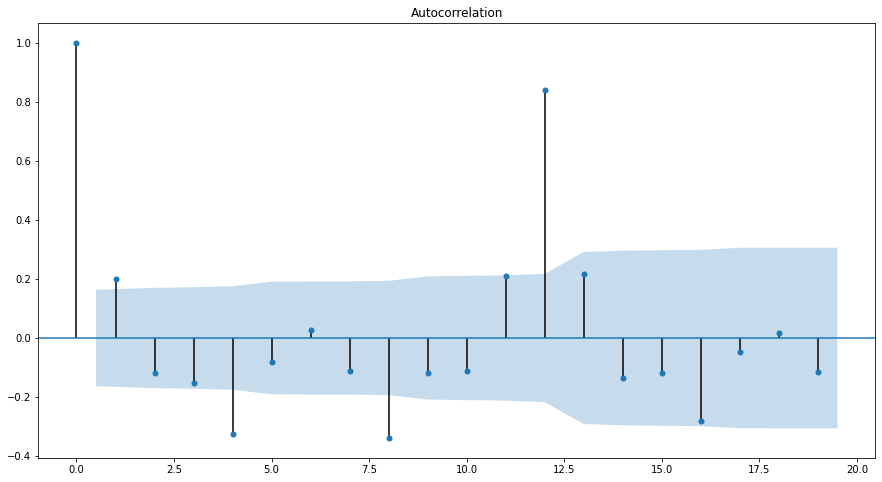

In [82]:
#ACF
plot_acf(df_diff, lags = range(0, 20))
plt.show()

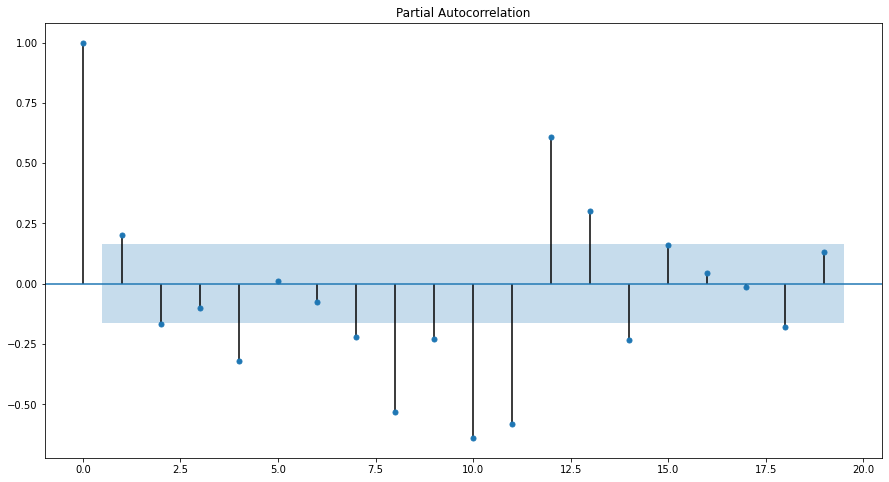

In [83]:
#PACF
plot_pacf(df_diff, lags = range(0, 20))
plt.show()


#The shaded regions in the plots are the confidence intervals. The lags where the PACF #and ACF charts cross this region are the values for p and q respectively. In both plots, #p=q=1.

#The shaded regions in the plots are the confidence intervals. The lags where the PACF and #ACF charts cross this region are the values for p and q respectively. 
#In the ACF plot, there is one lag that crosses the significance level hence, q=1. Similarly #in the PACF plot, p=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



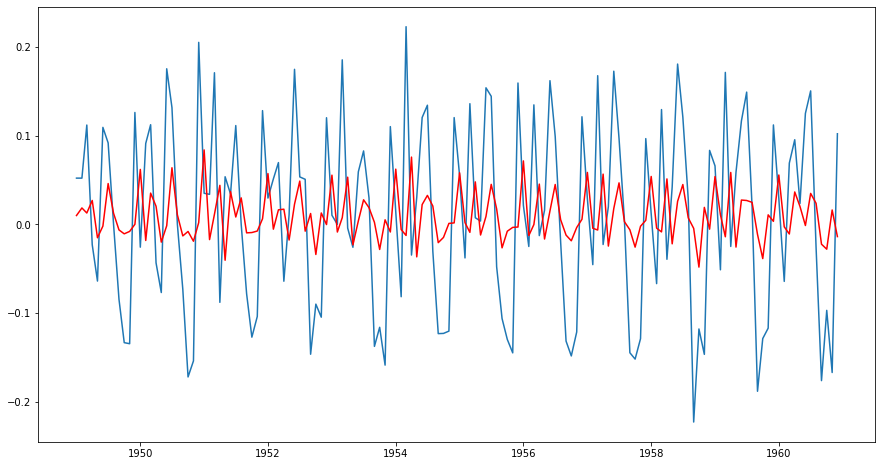

In [84]:
#AR, MA and ARIMA
from statsmodels.tsa.arima_model import ARIMA
#(p,d,q)
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color='red')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



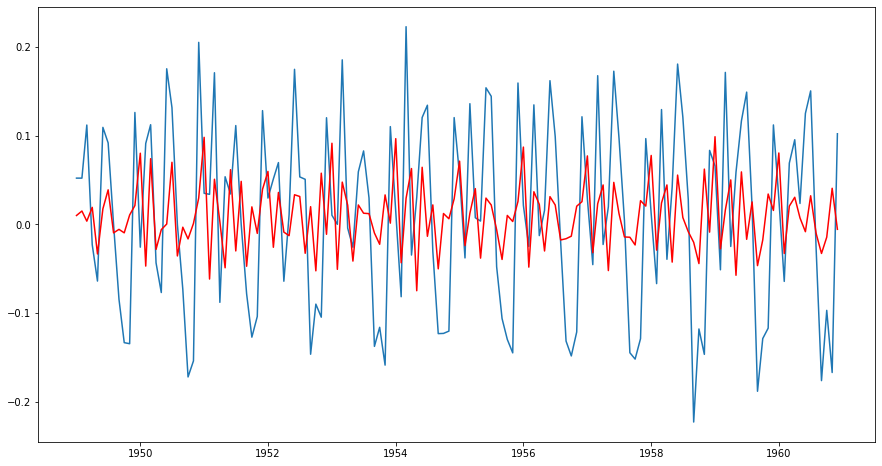

In [85]:
MA_model = ARIMA(df_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color='red')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



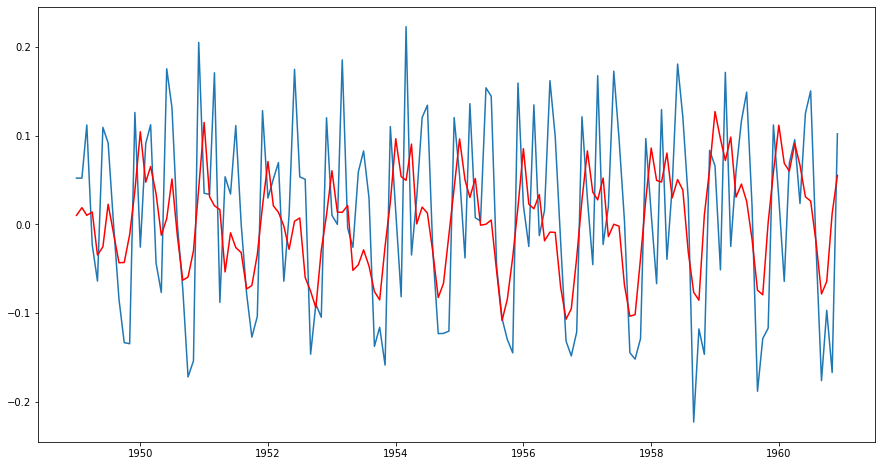

In [86]:
ARIMA_model = ARIMA(df_diff, order=(2,0,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color='red')

# Time Series at Scale

In [42]:
from fbprophet import Prophet
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df['Month']= pd.to_datetime(df['Month'])
df = df.rename(columns={"Month": "ds", "Passengers": "y"})
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [43]:
model = Prophet()
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
#predict for the next 10 months
future = model.make_future_dataframe(periods=10, freq='M') 
forecast = model.predict(future) 
forecast.head()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,1949-01-01,84.807353,56.397015,112.684179,106.727984,106.727984,106.727984
1,1949-02-01,78.218354,51.561152,107.937592,108.901201,108.901201,108.901201
2,1949-03-01,110.361397,81.429197,139.750949,110.864107,110.864107,110.864107
3,1949-04-01,107.851823,80.858504,136.242577,113.037323,113.037323,113.037323
4,1949-05-01,111.351735,85.020617,138.958718,115.140437,115.140437,115.140437
...,...,...,...,...,...,...,...
149,1961-05-31,533.992919,506.047516,564.059930,502.558318,502.360259,502.715397
150,1961-06-30,577.062353,551.027929,606.584205,505.571811,505.320681,505.774328
151,1961-07-31,575.495626,544.972216,603.211985,508.685754,508.379365,508.931679
152,1961-08-31,529.069236,500.677121,556.466130,511.799697,511.426925,512.102338


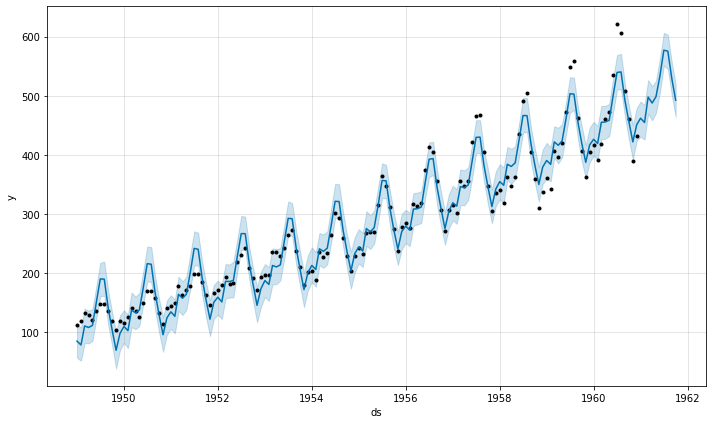

In [45]:
model.plot(forecast)
plt.show()